In [3]:
#general
import numpy as np; import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt; import copy
#torch
import torch; import torch.nn as nn;
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, SGD
import torch.nn.functional as F

In [4]:
path = './input/'
#train: (59000, 28, 28)
train_images = np.load(path+'kmnist-train-imgs.npz')['arr_0']/255
train_labels = np.load(path+'kmnist-train-labels.npz')['arr_0']
#val: (1000, 28, 28)
val_images = np.load('./input/kmnist-val-imgs.npz')['arr_0']/255
val_labels = np.load('./input/kmnist-val-labels.npz')['arr_0']
#test: (10000, 28, 28)
test_images = np.load(path+'kmnist-test-imgs.npz')['arr_0']/255
test_labels = np.load(path+'kmnist-test-labels.npz')['arr_0']

In [5]:
#transform train, val, test datasets
transform_train= transforms.Compose([
    #Normalize the data to range of (-1,1) <0.3 mark>:
        #explanation: all 'images' datasets have already been divided by 255, thus range = [0, 1]
        #by normalizing [0, 1] with mean, std = 0.5, 0.5, new range = [(0-0.5)/0.5=-1, (1-0.5)/0.5=1] = [-1, 1]
    transforms.Normalize(mean=(0.5), std=(0.5)),
    #Randomly flip the image left and right <0.3 mark>:
        #simply following the documentation here： p=0.5 -> probability of flip = 50%
    transforms.RandomHorizontalFlip(p=0.5),
    #Zero-pad 4 pixels on each side of the input image and randomly crop 28x28 as input <0.3 mark>:
        #simply following the documentation here
    transforms.Pad(padding=2, fill=0),
    transforms.RandomCrop(size=(28, 28))  
])
#for val and test images:
transform_valTest= transforms.Compose([
    transforms.Normalize(mean=(0.5), std=(0.5))
])

class KmnistDataset(Dataset):
    #three variables: the image and label datasets, and the tranform option
    def __init__(self, image_data, image_label, transform=None):
        #format the data type of image_data and image_label, and convert from numpy to torch
        #image_data
        self.image_data = torch.from_numpy(image_data).float() #torch.Size([59000, 28, 28]) 
        self.image_data = self.image_data.unsqueeze(1) #torch.Size([59000, 1, 28, 28])
        #image_label
        self.image_label = torch.from_numpy(image_label).long()
        #trainsform
        self.transform = transform #can take the train/test transform variable
    #to get individual image_data/image_label tensors based on index       
    def __getitem__(self, idx):
        x = self.image_data[idx]
        y = self.image_label[idx]
        
        if self.transform:
            x = self.transform(x)
        return x, y
    #return the data count e.g. 59000 for train_imgages
    def __len__(self):
        #only need one because image and label ct should be the same
        return len(self.image_data)

#hyper-parameters:
batch_size = 64
num_epoch = 50
learning_rate = 0.001

#apply KminstDatset and torch....Dataloader, create three dataloader object variables (train, val, test):
trainDataset = KmnistDataset(train_images, train_labels, transform_train) #using trainsform_train for train data
train_dl = DataLoader(trainDataset, batch_size=batch_size, shuffle=True)

valDataset = KmnistDataset(val_images, val_labels, transform_valTest)
val_dl = DataLoader(valDataset, batch_size=batch_size, shuffle=False)

testDataset = KmnistDataset(test_images, test_labels, transform_valTest)
test_dl = DataLoader(testDataset, batch_size=batch_size, shuffle=False)

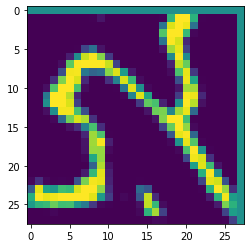

In [6]:
image, label = trainDataset.__getitem__(3)
#torch.squeeze: Returns a tensor with all the dimensions of input of size 1 removed.
#For example, if input is of shape: (A \times 1 \times B \times C \times 1 \times D)(A×1×B×C×1×D)
#then the out tensor will be of shape: (A \times B \times C \times D)(A×B×C×D).
image = torch.squeeze(image)
plt.imshow(image)

In [7]:
def KmnistCNN():
    model = nn.Sequential(
        #5×5 Convolutional Layer with 32 filters, stride 1 and padding 2
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2),
        #ReLU Activation Layer
        nn.ReLU(),
        #2×2 Max Pooling Layer with a stride of 2
        nn.MaxPool2d(2, 2),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
        #ReLU Activation Layer
        nn.ReLU(),
        #2×2 Max Pooling Layer with a stride of 2
        nn.MaxPool2d(2, 2),#torch.Size([n, 64, 7, 7])
        #Flatten the data to take nn.Linear
        nn.Flatten(), 
        #Fully-connected layer with 1024 output units
        nn.Linear(64*7*7, 1024),
        #ReLU Activation Layer
        nn.ReLU(),
        #Fully-connected layer with 10 output units.
        nn.Linear(1024, 10)
    )
    return model

def train(model, loss_func, optimizer, train_dl, val_dl, num_epoch):
    train_accuracy, val_accuracy = [], []
    train_loss, val_loss = [], []
    current_best_accuracy = 0
    print('Start Training')
    for epoch in range(num_epoch):
        model.train()
        match, tr_loss, total = 0, 0, 0
        for i, (images, labels) in enumerate(train_dl):
            optimizer.zero_grad()
            output = model(images)
            #torch.max(input, dim, keepdim=False, *, out=None)
            #dim (int) – the dimension to reduce.
            value, pred = torch.max(output,1)
            #count the number of match: predicitons = labels
            match += torch.sum(pred == labels).item()
            loss = loss_func(output, labels)
            tr_loss += loss.item() * images.shape[0]
            total += output.size(0)
            #backward propagation & optmize
            loss.backward()
            optimizer.step()
            if i % 100 == 0:
                print('Epoch '+str(epoch+1) + ' - '+str(i)+': ', round(match*1.0/total, 3))
        #training & validation accuracy
        t_accuracy = float(match*1.0/total)
        v_accuracy, v_loss = validation(model, val_dl, loss_func) #!
        train_accuracy.append(t_accuracy)
        val_accuracy.append(v_accuracy)
        #training & validation loss
        train_loss.append(float(tr_loss*1.0/total))
        val_loss.append(v_loss)
        #best model:
        if v_accuracy > current_best_accuracy:
            #defining the best model with accuracy_t > max[accuracy_0...accuracy_t-1]
            x_model = copy.deepcopy(model)
            #current best accuracy becomes the new 'accuracy benchmark'
            current_best_accuracy = v_accuracy
        #print intermeidate results:
        print('Epoch:', epoch+1, ", Validation Accuracy:", round(v_accuracy,3),
              ', Training Accuracy:', round(t_accuracy, 3),', Current Best Accuracy (Validation):',
              round(current_best_accuracy,3), ', Validation Loss:', round(v_loss,3), ', Training Loss:',
              round(float(tr_loss*1.0/total), 3))
    #output tables:
    accuracy_table = pd.DataFrame({'Epoch':list(range(num_epoch)), 'Validation Accuracy':val_accuracy,\
                                   'Training Accuracy':train_accuracy})
    accuracy_table['Epoch'] = accuracy_table['Epoch'] + 1
    loss_table = pd.DataFrame({'Epoch':list(range(num_epoch)), 'Validation Loss':val_loss,\
                                   'Training Loss':train_loss})
    loss_table['Epoch'] = loss_table['Epoch'] + 1
    print('Complete Training')
    return x_model, accuracy_table, loss_table

#validation and testing processes are mostly the same
def validation(training_model, val_dl, loss_func):
    match, v_loss, total = 0, 0, 0
    for i, (images, labels) in enumerate(val_dl):
        output = training_model(images)
        value, pred = torch.max(output,1)
        match += torch.sum(pred == labels)
        #calculate loss
        loss = loss_func(output, labels)
        v_loss += loss.item() * images.shape[0]
        #total += batch size
        total += output.size(0)
    accuracy = float(match*1.0/total)
    loss_ = float(v_loss*1.0/total)
    return accuracy, loss_

#test_trained_model is used after the model has trained
def test_trained_model(trained_model, test_dl):
    with torch.no_grad():
        pred_values, true_values = [], []
        for i, (images, labels) in enumerate(test_dl):
            output = trained_model(images)
            #output example:
            #[-3.2670e+00, -4.1978e+00,  1.6820e+00,  3.8642e+00,  1.8179e+00,
             #-4.5547e+00, -2.5565e+00, -5.5834e+00,  2.0556e+00, -1.0957e+00]
                #....
            #predicted result = output with "highest weighting 0-9"
            value, pred = torch.max(output, 1) #value and index = prediction
            #store prediction and ground truth output into lists
            #Tensor.numpy() → numpy.ndarray
            pred_values.extend(list(pred.numpy()))
            true_values.extend(list(labels.numpy()))
    return np.array(pred_values), np.array(true_values)

def lineGraph(df, title, y_axis):
    line1, = plt.plot(df[df.columns[0]], df[df.columns[1]], label=df.columns[1])
    line2, = plt.plot(df[df.columns[0]], df[df.columns[2]], label=df.columns[2])
    plt.xticks(list(df[df.columns[0]]))
    plt.xlabel('Epochs')
    plt.ylabel(y_axis)
    plt.suptitle(title)
    plt.legend(loc='best')
    plt.show()

In [8]:
learning_rate = 0.001
model = KmnistCNN()
loss_func = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999))
batch_size = 64
num_epoch = 3

#train model: get best model (i.e. with max accuracy) and accuracy table
trained_model, accuracy_table, loss_table = train(model, loss_func, optimizer, train_dl, val_dl, num_epoch)
#test the performance of the trained model using the test_dl (test_images, test_labels)
pred_values, true_values = test_trained_model(trained_model, test_dl) #get predicted and actual classificaton values

Start Training
Epoch 1 - 0:  0.141
Epoch 1 - 100:  0.579
Epoch 1 - 200:  0.689
Epoch 1 - 300:  0.746
Epoch 1 - 400:  0.782
Epoch 1 - 500:  0.806
Epoch 1 - 600:  0.826
Epoch 1 - 700:  0.84
Epoch 1 - 800:  0.852
Epoch 1 - 900:  0.862
Epoch: 1 , Validation Accuracy: 0.948 , Training Accuracy: 0.864 , Current Best Accuracy (Validation): 0.948 , Validation Loss: 0.173 , Training Loss: 0.427
Epoch 2 - 0:  0.938
Epoch 2 - 100:  0.949
Epoch 2 - 200:  0.949
Epoch 2 - 300:  0.952
Epoch 2 - 400:  0.952
Epoch 2 - 500:  0.952
Epoch 2 - 600:  0.953
Epoch 2 - 700:  0.954
Epoch 2 - 800:  0.955
Epoch 2 - 900:  0.955
Epoch: 2 , Validation Accuracy: 0.976 , Training Accuracy: 0.956 , Current Best Accuracy (Validation): 0.976 , Validation Loss: 0.105 , Training Loss: 0.142
Epoch 3 - 0:  1.0
Epoch 3 - 100:  0.967
Epoch 3 - 200:  0.967
Epoch 3 - 300:  0.967
Epoch 3 - 400:  0.968
Epoch 3 - 500:  0.968
Epoch 3 - 600:  0.968
Epoch 3 - 700:  0.968
Epoch 3 - 800:  0.968
Epoch 3 - 900:  0.969
Epoch: 3 , Validatio

Test Accuracy Result:  0.9418


,0,1,2,3,4,5,6,7,8,9
0,950,5,3,0,6,8,0,23,1,4
1,6,931,5,0,9,0,23,2,15,9
2,12,30,874,32,4,7,12,10,16,3
3,1,0,7,974,0,4,7,4,2,1
4,13,5,2,3,926,3,11,5,25,7
5,6,34,13,4,1,919,17,0,2,4
6,2,8,11,1,6,0,970,2,0,0
7,3,23,4,0,3,2,5,952,2,6
8,2,10,2,1,3,2,1,4,971,4
9,10,5,1,1,3,1,7,12,9,951


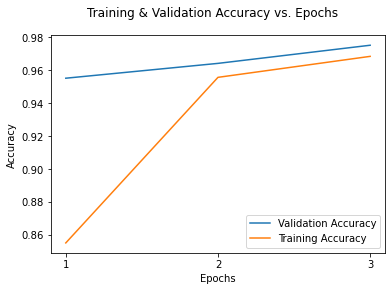

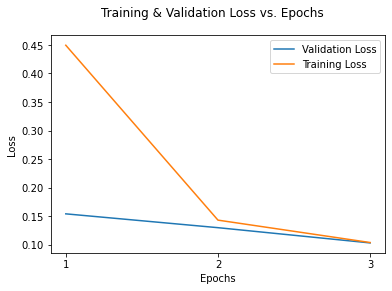

In [71]:
#create a table to store predicted v.s. ground truth data output
pt = pd.DataFrame({'Pred':pred_values, 'True':true_values})
#create a confusion matrix, a very handy function to visualize the model's performance with each of the classifiers [1, 10]
cm = pd.DataFrame(confusion_matrix(true_values, pred_values, labels=np.arange(0,10)))
print('Test Accuracy Result: ', pt[pt['Pred']==pt['True']]['Pred'].count()/pt['Pred'].count())
display(cm)

lineGraph(accuracy_table, 'Training & Validation Accuracy vs. Epochs', 'Accuracy')
lineGraph(loss_table, 'Training & Validation Loss vs. Epochs', 'Loss')